In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
data_path = '../../data/postprocessed/PC/'

mapping_table = {
    'backprop': 'Backpropagation algorithm',
    'gaussian': 'Gaussian Elimination',
    'gpu': 'Stream Cluster',
    'lenet': 'Lenet5',
    'gpuburn': 'GPU-burn'
}

data_sheet = pd.DataFrame()
for csv_name in [file for file in os.listdir(data_path) if not file.endswith('_telemetry.csv') and not file.startswith('srad')]:
    csv_full_path = os.path.join(data_path, csv_name)
    print(csv_full_path)
    df = pd.read_csv(csv_full_path)
    df['Range'] = int(csv_name.split('_')[1].split('.')[0])
    df['App_name'] = mapping_table[csv_name.split('_')[0]]

    data_sheet=pd.concat([data_sheet, df], ignore_index=True)

../../data/postprocessed/backprop_4.csv
../../data/postprocessed/backprop_1.csv
../../data/postprocessed/gpuburn_5.csv
../../data/postprocessed/gpuburn_3.csv
../../data/postprocessed/backprop_2.csv
../../data/postprocessed/gaussian_5.csv
../../data/postprocessed/backprop_3.csv
../../data/postprocessed/gaussian_4.csv
../../data/postprocessed/lenet_3.csv
../../data/postprocessed/lenet_1.csv
../../data/postprocessed/gpuburn_1.csv
../../data/postprocessed/gaussian_1.csv
../../data/postprocessed/gaussian_3.csv
../../data/postprocessed/lenet_5.csv
../../data/postprocessed/lenet_4.csv
../../data/postprocessed/gpuburn_4.csv
../../data/postprocessed/lenet_2.csv
../../data/postprocessed/gpuburn_2.csv
../../data/postprocessed/backprop_5.csv
../../data/postprocessed/gaussian_2.csv


## Fixing the set of computed metrics across all the experiments

### I want to check if the number of Kernel Injection (Range) affects the number of run sessions.

In [3]:
for label in sorted(data_sheet['Range'].unique()):
    print("--------------------------------------------------------------------")
    print(f'Number of times a kernel is executed for metric computation: {label}') 
    print(f"Instances: {len(data_sheet[data_sheet['Range']==label])}")

--------------------------------------------------------------------
Number of times a kernel is executed for metric computation: 1
Instances: 55524
--------------------------------------------------------------------
Number of times a kernel is executed for metric computation: 2
Instances: 55524
--------------------------------------------------------------------
Number of times a kernel is executed for metric computation: 3
Instances: 55545
--------------------------------------------------------------------
Number of times a kernel is executed for metric computation: 4
Instances: 55524
--------------------------------------------------------------------
Number of times a kernel is executed for metric computation: 5
Instances: 55545


### Apparently not

### Thus, it must be dependent only on the application complexity

In [4]:
for label in mapping_table.values():
    print("--------------------------------------------------------------------")
    print(f'App name: {label}') 
    print(f"Instances: {len(data_sheet[data_sheet['App_name']==label])}")

--------------------------------------------------------------------
App name: Backpropagation algorithm
Instances: 210
--------------------------------------------------------------------
App name: Gaussian Elimination
Instances: 214830
--------------------------------------------------------------------
App name: Stream Cluster
Instances: 0
--------------------------------------------------------------------
App name: Lenet5
Instances: 57120
--------------------------------------------------------------------
App name: GPU-burn
Instances: 5502


### Considerations
1. Complexity does not imply stress
2. I think that the complexity is due also to the number of kernels that the application comprises

TODO: look at Future works

In [5]:
data_sheet['rollup_operation'].unique()
# It is a useless column, we can drop it
data_sheet = data_sheet.drop('rollup_operation', axis=1)

### Available data

In [6]:
location_mapping={
    'lts': 'L2 Cache',
    'sm': 'Streaming Multiprocessor',
    'smsp': 'Streaming Multiprocessor Subpartition',
    'sys': 'System (aggregated info)',
    'dram': 'Dynamic RAM'
}
data_sheet['location'].unique()

array(['sm', 'sys', 'smsp', 'dram', 'lts'], dtype=object)

In [7]:
data_sheet['HR_location'] = data_sheet['location'].map(location_mapping)
data_sheet.drop('location', axis=1, inplace=True)

In [8]:
metric_event_mapping= {
    'cycles_active': 'Active cycles',
    'warps_active': 'Active warps',
    'inst_executed_op_generic_atom_dot_alu': 'Atomic ALU operations',
    'cycles_elapsed': 'Total elapsed cycles',
    'inst_executed_op_generic_atom_dot_cas': 'CAS atomic operatiions on global memory',
    'inst_executed_op_global_red': 'Global reduction',
    'inst_executed': 'Executed instructions',
    'inst_executed_pipe_fma': 'Executed FMA instructions',
    'inst_executed_pipe_fp64': 'Executed Double Precision instructions',
    'inst_issued': 'Issued instructions',
    't_sectors_op_read_lookup_miss': 'miss',
    'warps_launched': 'Executing warps',
    'thread_inst_executed': 'Executed thread instructions',
    'inst_executed_op_local_st': 'Executed instructions involving local memory store (write)',
    'inst_executed_op_local_ld': 'Executed instruction involving local memory load (read)',
    'inst_executed_op_global_st': 'Executed instructions involving global memory store (write)',
    'inst_executed_op_global_ld': 'Executed instructions involving global memory load (read)',
    'sectors_write':'Written memory partition',
    'sectors_read':'Read memory partition'
}
data_sheet['metric_name'].unique()

array(['cycles_active', 'warps_active',
       'inst_executed_op_generic_atom_dot_alu', 'cycles_elapsed',
       'sectors_read', 'sectors_write',
       'inst_executed_op_generic_atom_dot_cas',
       'inst_executed_op_global_red', 'inst_executed',
       'inst_executed_pipe_fma', 'inst_executed_pipe_fp64', 'inst_issued',
       't_sectors_op_read_lookup_miss', 'warps_launched',
       'thread_inst_executed', 'inst_executed_op_local_st',
       'inst_executed_op_local_ld', 'inst_executed_op_global_st',
       'inst_executed_op_global_ld'], dtype=object)

In [9]:
data_sheet['HR_metric_name'] = data_sheet['metric_name'].map(metric_event_mapping)
data_sheet.drop('metric_name', axis=1, inplace=True)

### Let's fix for a second the Number of times a kernel is executed for metric computations to 1

In [10]:
data_sheet_1 = data_sheet[data_sheet['Range']==1]

### Regardless of the application I want to see the correlation within the columns

In [11]:
df_l2_1 = data_sheet_1[data_sheet_1['HR_location']=='L2 Cache']
df_sm_1 = data_sheet_1[data_sheet_1['HR_location']=='Streaming Multiprocessor']
df_smsp_1 = data_sheet_1[data_sheet_1['HR_location']=='Streaming Multiprocessor Subpartition']
df_sys_1 = data_sheet_1[data_sheet_1['HR_location']=='System (aggregated info)']
df_dram_1 = data_sheet_1[data_sheet_1['HR_location']=='Dynamic RAM']

dfs = {
    'L2 Cache': df_l2_1, 
    'Streaming Multiprocessor': df_sm_1, 
    'Streaming Multiprocessor Subpartition': df_smsp_1, 
    'System (Aggregated info)': df_sys_1, 
    'Dynamic RAM': df_dram_1
    }

In [12]:
df_pivot_l2_1 = df_l2_1.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_sm_1 = df_sm_1.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_smsp_1 = df_smsp_1.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_sys_1 = df_sys_1.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_dram_1 = df_dram_1.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

pivot_dfs = {
    'L2 Cache': df_pivot_l2_1, 
    'Streaming Multiprocessor': df_pivot_sm_1, 
    'Streaming Multiprocessor Subpartition': df_pivot_smsp_1, 
    'System (Aggregated info)': df_pivot_sys_1, 
    'Dynamic RAM': df_pivot_dram_1
    }

In [13]:
metric_full_name = data_sheet_1['HR_location'] +' '+ data_sheet_1['HR_metric_name']
metric_full_name.unique()

array(['Streaming Multiprocessor Active cycles',
       'System (aggregated info) Active cycles',
       'Streaming Multiprocessor Active warps',
       'Streaming Multiprocessor Subpartition Atomic ALU operations',
       'Streaming Multiprocessor Total elapsed cycles',
       'System (aggregated info) Total elapsed cycles',
       'Dynamic RAM Read memory partition',
       'Dynamic RAM Written memory partition',
       'Streaming Multiprocessor Subpartition CAS atomic operatiions on global memory',
       'Streaming Multiprocessor Subpartition Global reduction',
       'Streaming Multiprocessor Executed instructions',
       'Streaming Multiprocessor Subpartition Executed FMA instructions',
       'Streaming Multiprocessor Subpartition Executed Double Precision instructions',
       'Streaming Multiprocessor Issued instructions', 'L2 Cache miss',
       'Streaming Multiprocessor Subpartition Executing warps',
       'Streaming Multiprocessor Subpartition Executed thread instructions

In [14]:
df_pivot_dram_1

HR_metric_name,session_id,HR_location,range_name,Range,App_name,Read memory partition,Written memory partition
0,1,Dynamic RAM,0,1,Backpropagation algorithm,0.0,6224.0
1,1,Dynamic RAM,0,1,GPU-burn,144349000.0,8861300.0
2,1,Dynamic RAM,0,1,Gaussian Elimination,0.0,24.0
3,1,Dynamic RAM,0,1,Lenet5,8.0,192.0
4,2,Dynamic RAM,0,1,Backpropagation algorithm,8.0,279728.0
...,...,...,...,...,...,...,...
2639,2042,Dynamic RAM,0,1,Gaussian Elimination,0.0,104.0
2640,2043,Dynamic RAM,0,1,Gaussian Elimination,0.0,32.0
2641,2044,Dynamic RAM,0,1,Gaussian Elimination,80.0,428.0
2642,2045,Dynamic RAM,0,1,Gaussian Elimination,0.0,32.0


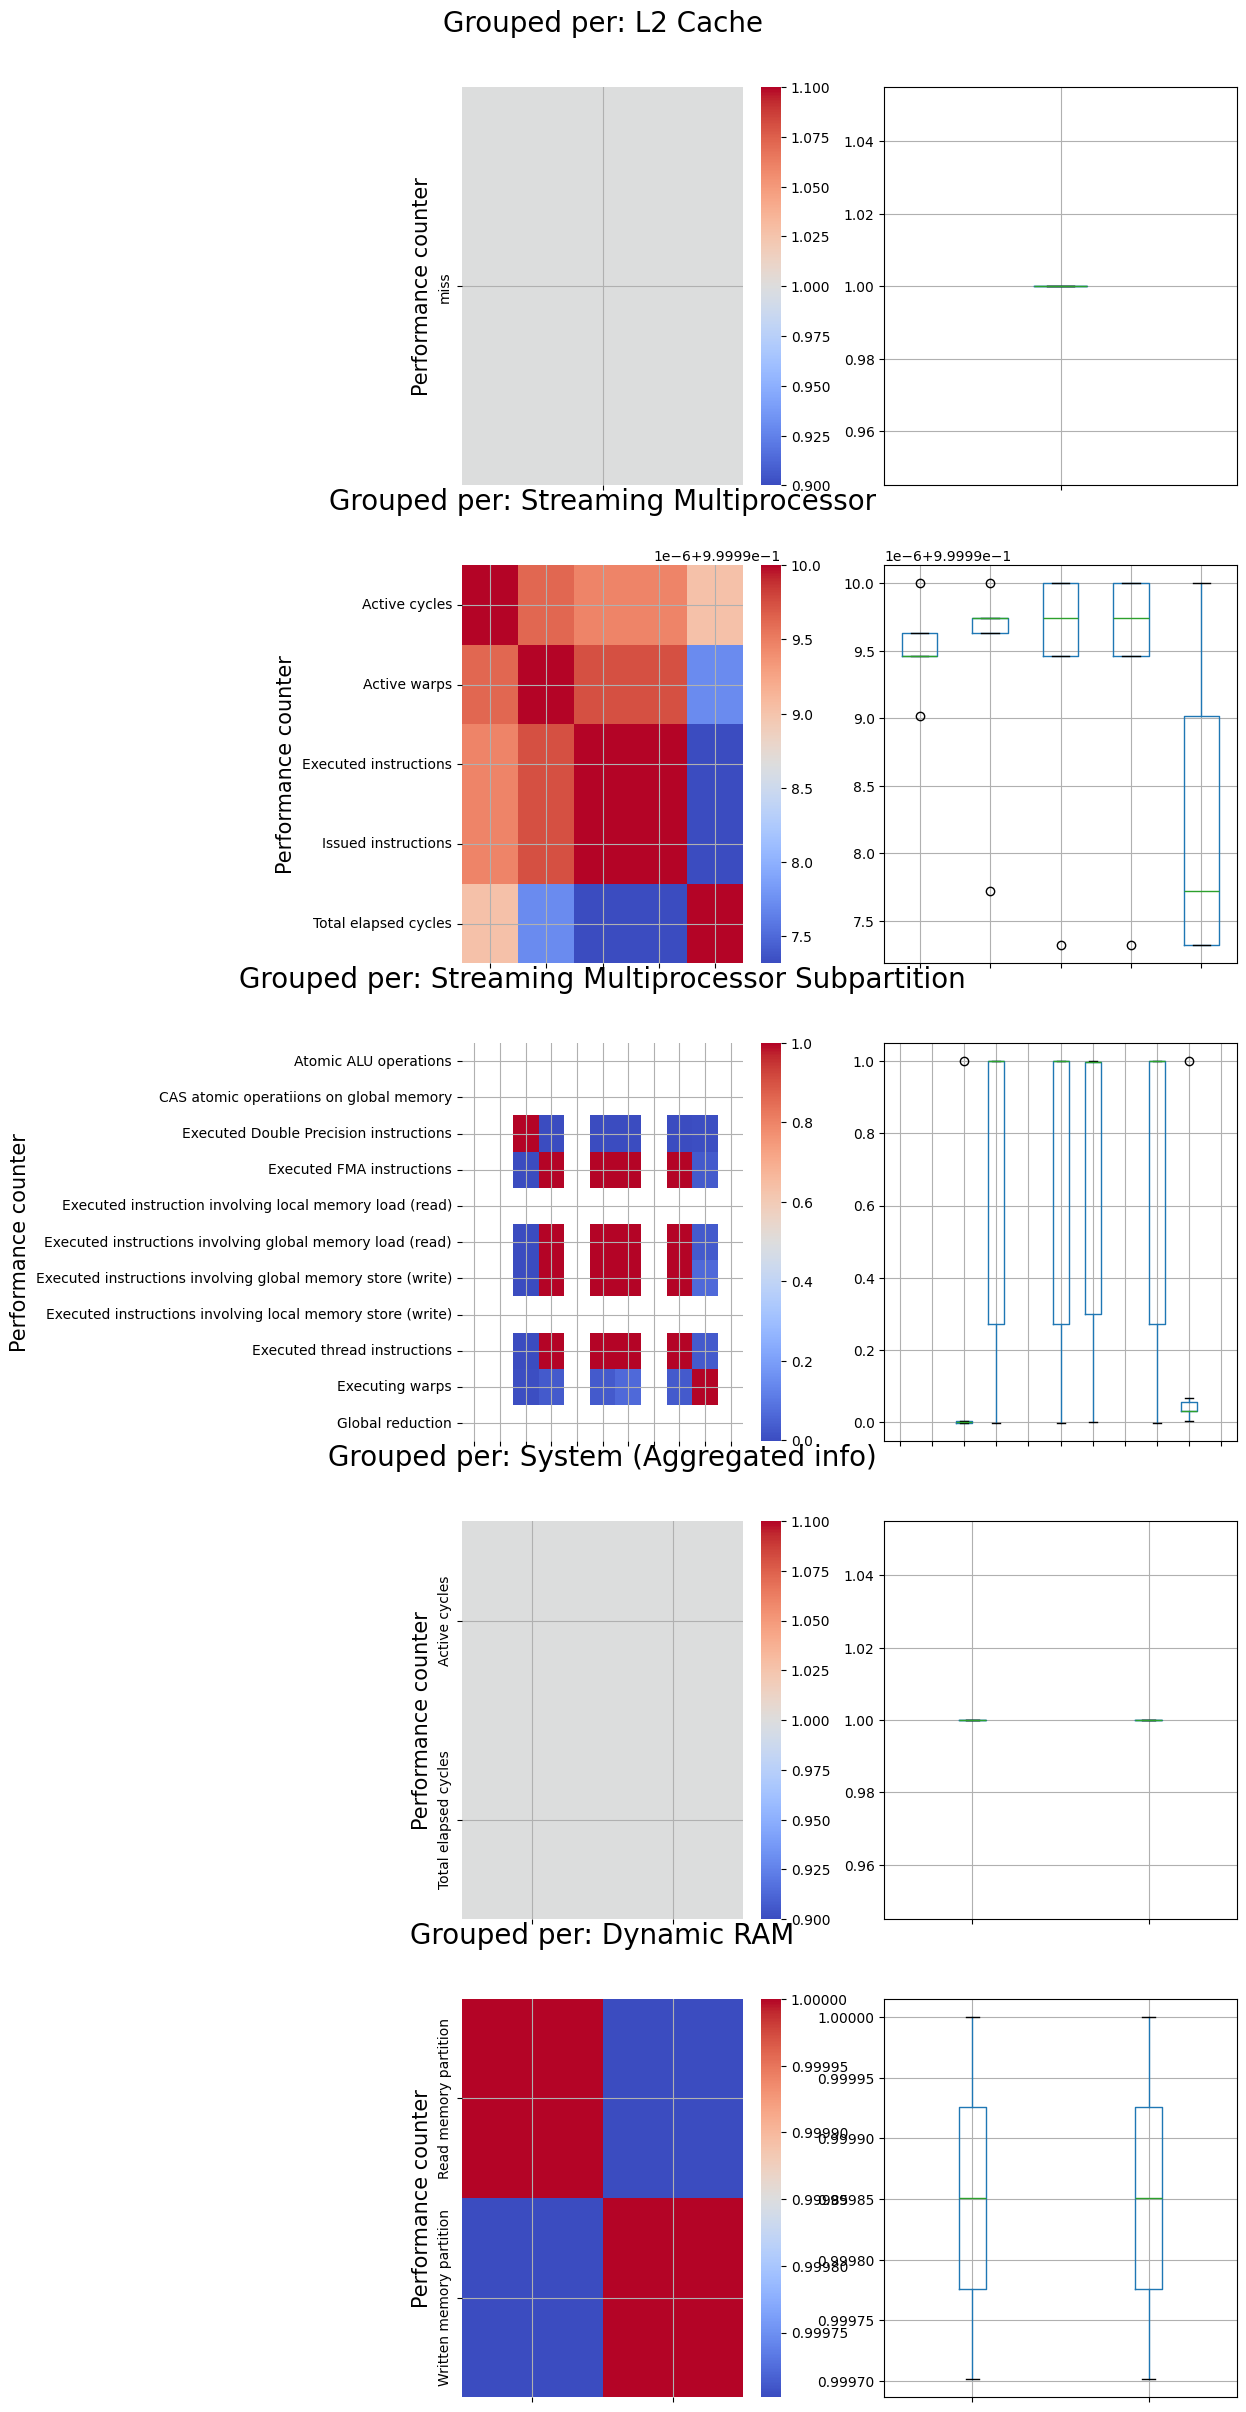

In [15]:
fig, ax = plt.subplots(5,2,figsize=(10,30))
for pivot_df_idx in range(len(list(pivot_dfs.values()))):
    HR_location = list(pivot_dfs.keys())[pivot_df_idx]
    # print(pivot_dfs[HR_location].select_dtypes(include=['float64']))
    # data_to_corr = pivot_dfs[HR_location][cols_to_corr]
    # target_data = data_to_corr.drop('HR_location', axis = 1)
    data_to_corr = pivot_dfs[HR_location].select_dtypes(include=['float64'])
    matrix = data_to_corr.corr()
    matrix.boxplot(ax=ax[pivot_df_idx][1])
    sns.heatmap(matrix, annot=False, cmap='coolwarm', ax=ax[pivot_df_idx][0])
    ax[pivot_df_idx][0].set_title(f"Grouped per: {HR_location}", fontsize=20, pad=40)
    ax[pivot_df_idx][0].grid()
    ax[pivot_df_idx][0].set_xlabel('Performance counter', fontsize=15)
    ax[pivot_df_idx][0].set_ylabel('Performance counter', fontsize=15)
    ax[pivot_df_idx][1].tick_params(axis='x', labelrotation=90, labelsize=13)
    ax[pivot_df_idx][0].tick_params(axis='x', labelrotation=90, labelsize=13)
    ax[pivot_df_idx][0].set_xticklabels([])
    ax[pivot_df_idx][1].set_xticklabels([])
    ax[pivot_df_idx][0].set_xlabel('')

### Stress evaluation

In [16]:
reverse_location_mapping={
    'L2 Cache': 'lts',
    'Streaming Multiprocessor': 'sm',
    'Streaming Multiprocessor Subpartition': 'smsp',
    'System (Aggregated info)': 'sys',
    'Dynamic RAM': 'dram'
}

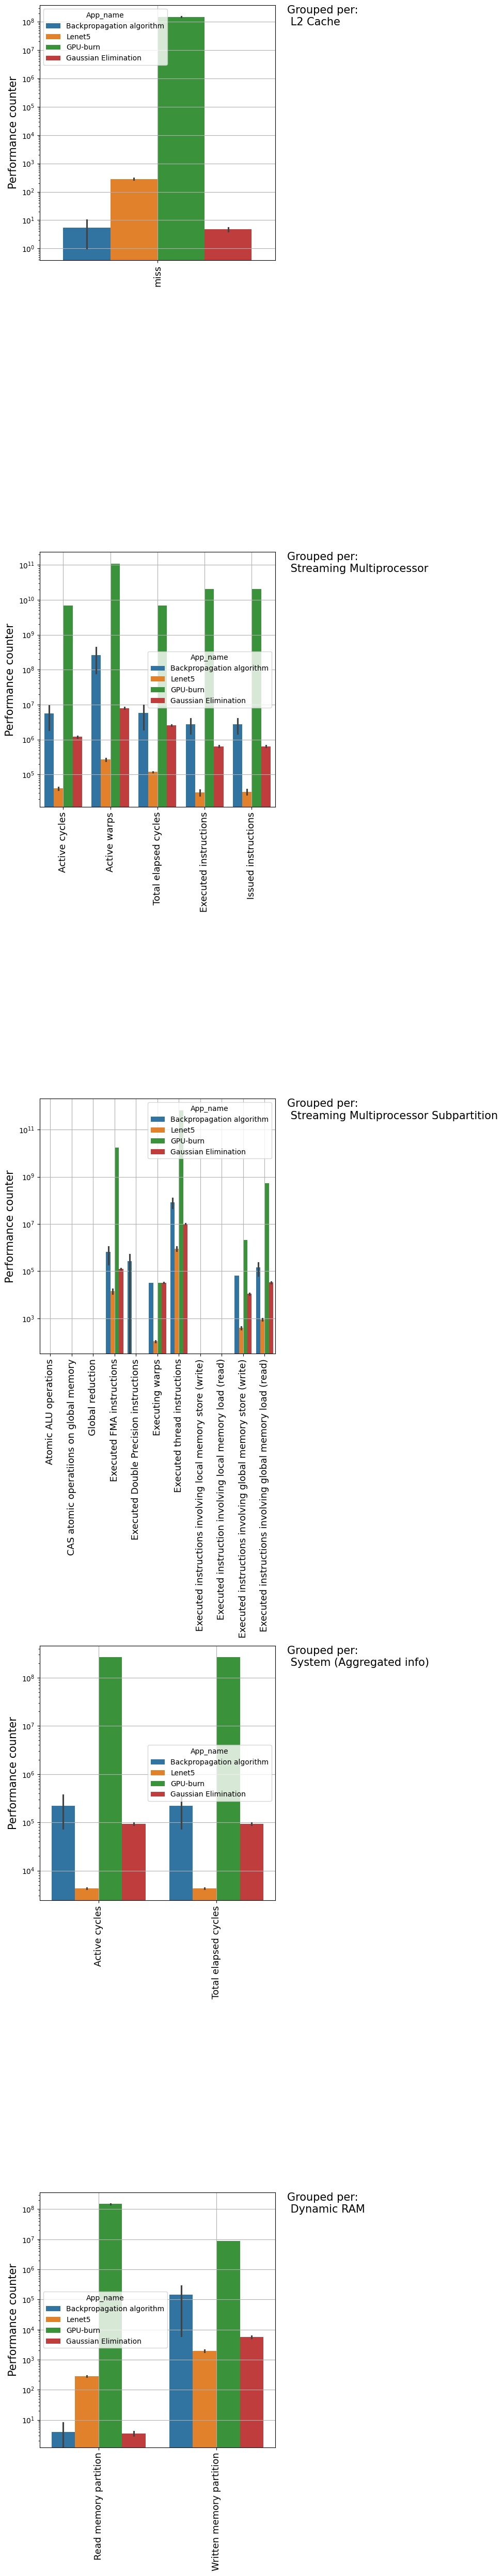

In [17]:
fig, ax = plt.subplots(5,1,figsize=(10,50))
for pivot_df_idx in range(len(list(dfs.values()))):
    HR_location = list(dfs.keys())[pivot_df_idx]
    # data_to_corr = dfs[HR_location].select_dtypes(include=['float64'])
    sns.barplot(data = dfs[HR_location], x='HR_metric_name', y='metric_value', hue='App_name', ax = ax[pivot_df_idx])
    # ax[pivot_df_idx].set_title(f"Grouped per: {HR_location}", fontsize=20, loc='right')
    ax[pivot_df_idx].text(1.05, 1.0, f'Grouped per: \n {HR_location}', transform=ax[pivot_df_idx].transAxes,
         ha='left', va='top', fontsize=15)
    ax[pivot_df_idx].grid()
    ax[pivot_df_idx].set_yscale('log')
    ax[pivot_df_idx].set_xlabel('Performance counter', fontsize=15)
    ax[pivot_df_idx].set_ylabel('Performance counter', fontsize=15)
    ax[pivot_df_idx].tick_params(axis='x', labelrotation=90, labelsize=13)
    # ax[pivot_df_idx].set_xticklabels([])
    ax[pivot_df_idx].set_xlabel('')
plt.tight_layout()

In [18]:
dfs['L2 Cache'].columns

Index(['session_id', 'range_name', 'metric_value', 'Range', 'App_name',
       'HR_location', 'HR_metric_name'],
      dtype='object')

/tmp/ipykernel_49227/1428112852.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[metric_idx].set_yscale('log')
/tmp/ipykernel_49227/1428112852.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[metric_idx].set_yscale('log')
/tmp/ipykernel_49227/1428112852.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[metric_idx].set_yscale('log')
/tmp/ipykernel_49227/1428112852.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[metric_idx].set_yscale('log')


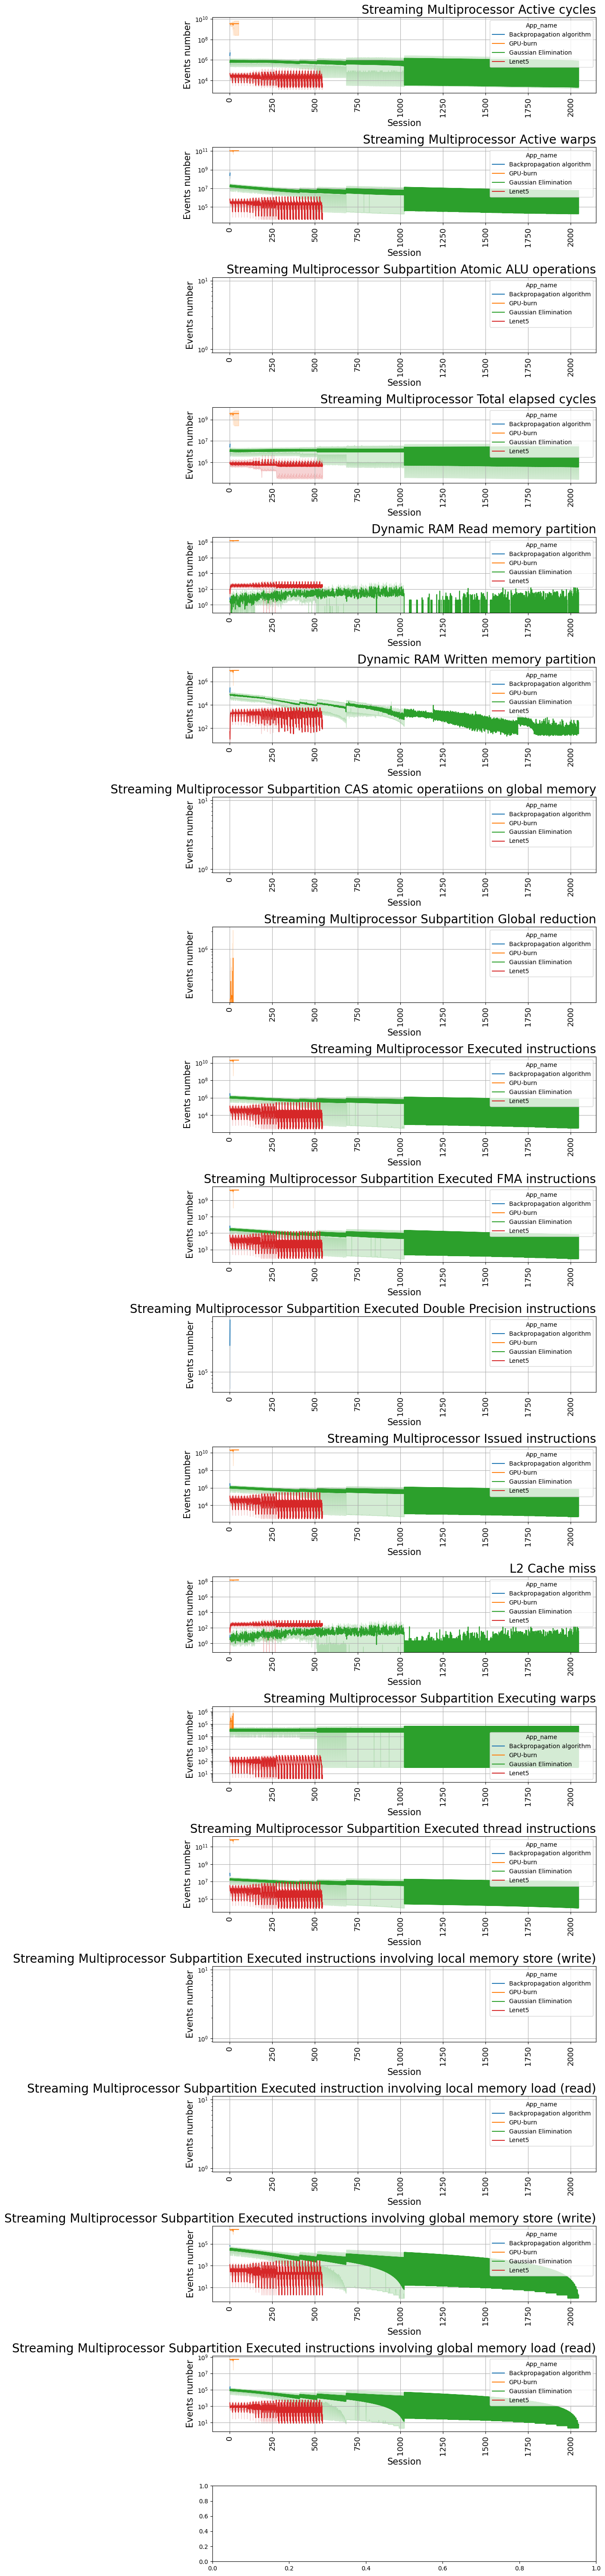

In [19]:
fig, ax = plt.subplots(20,1,figsize=(10,60))
for metric_idx in range(len(data_sheet['HR_metric_name'].unique())):
    metric_name = data_sheet['HR_metric_name'].unique()[metric_idx]
    data = data_sheet[data_sheet['HR_metric_name'] == metric_name]
    HR_location=data['HR_location'].unique()[0]
    sns.lineplot(data = data, x='session_id', y='metric_value', hue='App_name', ax = ax[metric_idx])
    ax[metric_idx].set_title(f"{HR_location} {metric_name}", fontsize=20, loc='right')
    # ax[metric_idx].text(1.05, 1.0, f'Grouped per: \n {HR_location}', transform=ax[metric_idx].transAxes,
    #      ha='left', va='top', fontsize=15)
    ax[metric_idx].grid()
    ax[metric_idx].set_yscale('log')
    ax[metric_idx].set_xlabel('Session', fontsize=15)
    ax[metric_idx].set_ylabel('Events number', fontsize=15)
    ax[metric_idx].tick_params(axis='x', labelrotation=90, labelsize=13)
    # ax[df_idx].set_xticklabels([])
plt.tight_layout()

### Final remarks
Ho una domanda gigantesca. Da che dipende il numero di Sessioni?
### Future works
1. Use the correlation ID to correlate instructions with SASS code 
2. Explore the possibility to use sass_source_map or sass_metrics
3. 